In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/'\
                    'PacktWorkshops/'\
                    'The-Data-Analysis-Workshop/'\
                    'master/Chapter01/data/hour.csv')
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Preprocessing Step
- Dropping the Unnecessary Columns.
- Variance Inflation Factor for Auto-Collinearity.
- Testing scaling and nonscaling features.

In [ ]:
unnecessary_columns = ['instant', 'dteday', 'yr']

preprocessed_data = df.drop(unnecessary_columns, axis=1)

In [ ]:
preprocessed_data.corr()[['registered', 'casual']]

,registered,casual
season,0.174226,0.120206
mnth,0.122273,0.068457
hr,0.374141,0.301202
holiday,-0.047345,0.031564
weekday,0.021578,0.032721
workingday,0.134326,-0.300942
weathersit,-0.120966,-0.152628
temp,0.335361,0.459616
atemp,0.332559,0.454080
hum,-0.273933,-0.347028


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = preprocessed_data.drop(['registered', 'casual', 'cnt'], axis=1)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                    for i in range(len(X.columns))]

vif_data.sort_values('VIF', ascending=False)

,feature,VIF
8,atemp,353.475746
7,temp,319.977942
0,season,21.131744
1,mnth,15.158870
9,hum,12.196732
6,weathersit,7.582791
2,hr,3.817434
10,windspeed,3.244810
5,workingday,3.230280
4,weekday,3.051266


- From the Variance Inflation Factor the atemp and season columns maybe dropped.

In [ ]:
# preprocessed_data.drop(['atemp', 'season'], axis=1, inplace=True)

In [ ]:
# def scale_column_by_100(col_name):
#     """
#     Scales the values in the specified column of a DataFrame by 100.
    
#     Parameters:
#         df (pandas.DataFrame): The DataFrame containing the column to be scaled.
#         col_name (str): The name of the column to be scaled.
    
#     Returns:
#         pandas.Series: The scaled column as a Series.
#     """
#     if col_name not in df.columns:
#         raise ValueError(f"Column '{col_name}' does not exist in DataFrame.")
    
#     scaled_col = df[col_name] * 100
#     return scaled_col


# # Define the columns to be scaled
# cols_to_scale = ['temp', 'atemp', 'hum']

# # Scale the columns using vectorized operations
# for col in cols_to_scale:
#     preprocessed_data[col] = scale_column_by_100(col)

- Splitting Data into features and target

In [ ]:
training_data = preprocessed_data.drop(['registered', 'casual', 'cnt'], axis=1)
y_reg = preprocessed_data['registered']
y_cas = preprocessed_data['casual']

- Models Comparison

GRB 47.51447604970381 0.8558352117850213
ELSN 91.02467979043263 1.0988843950637797
ByR 91.54833586418025 1.130871659919308
linr 91.60729755895312 1.1378872972705167
XGB 36.21952620959713 0.47079637977860017
DecT 46.50690135854492 0.6902154815038911
RNFR 36.437051742490446 0.447705806382167


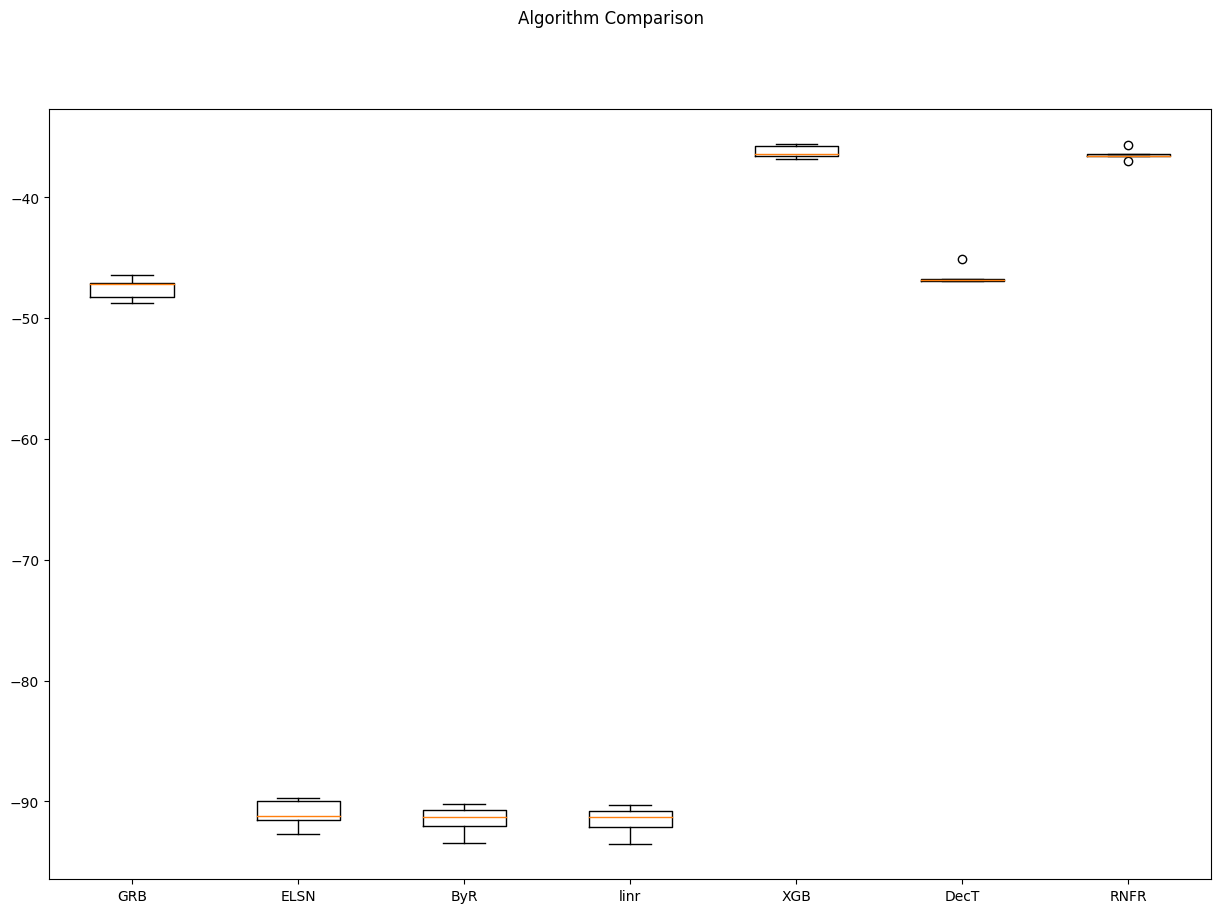

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
# from sklearn.kernel_ridge import KernelRidge
# from sklearn.svm import SVR
from sklearn.linear_model import (BayesianRidge, ElasticNet, LinearRegression)
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from xgboost.sklearn import XGBRegressor

models = [
    ('GRB', GradientBoostingRegressor()),
    # ('SVR', SVR()),
    # ('KernR', KernelRidge()),
    ('ELSN', ElasticNet()),
	('ByR', BayesianRidge()),
    ('linr', LinearRegression()),
    ('XGB', XGBRegressor()),
    ('DecT', DecisionTreeRegressor()),
    ('RNFR', RandomForestRegressor(max_depth=None, max_features='auto', min_samples_leaf=1, min_samples_split=2, n_estimators=500))
    ]
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=5, random_state=0, shuffle=True)
    cv_results = cross_val_score(model, training_data, y_reg, cv=kfold, scoring = 'neg_mean_absolute_error')
    results.append(cv_results)
    names.append(name)
    print(name, -1 * cv_results.mean(), cv_results.std())
# boxplot algorithm comparison
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.savefig('Figures/Model_Comparison_Registered.png', format='png')
plt.show()

GRB 13.059549990193645 0.2678233571334799
ELSN 24.453944332128934 0.47139033531430513
ByR 24.753955001005767 0.3536878801693018
linr 24.764060932219415 0.35344438428969466
XGB 9.990676845197449 0.24692949976279868
DecT 12.855318906209899 0.3619956326257072
RNFR 9.540628708603723 0.14463829368910372


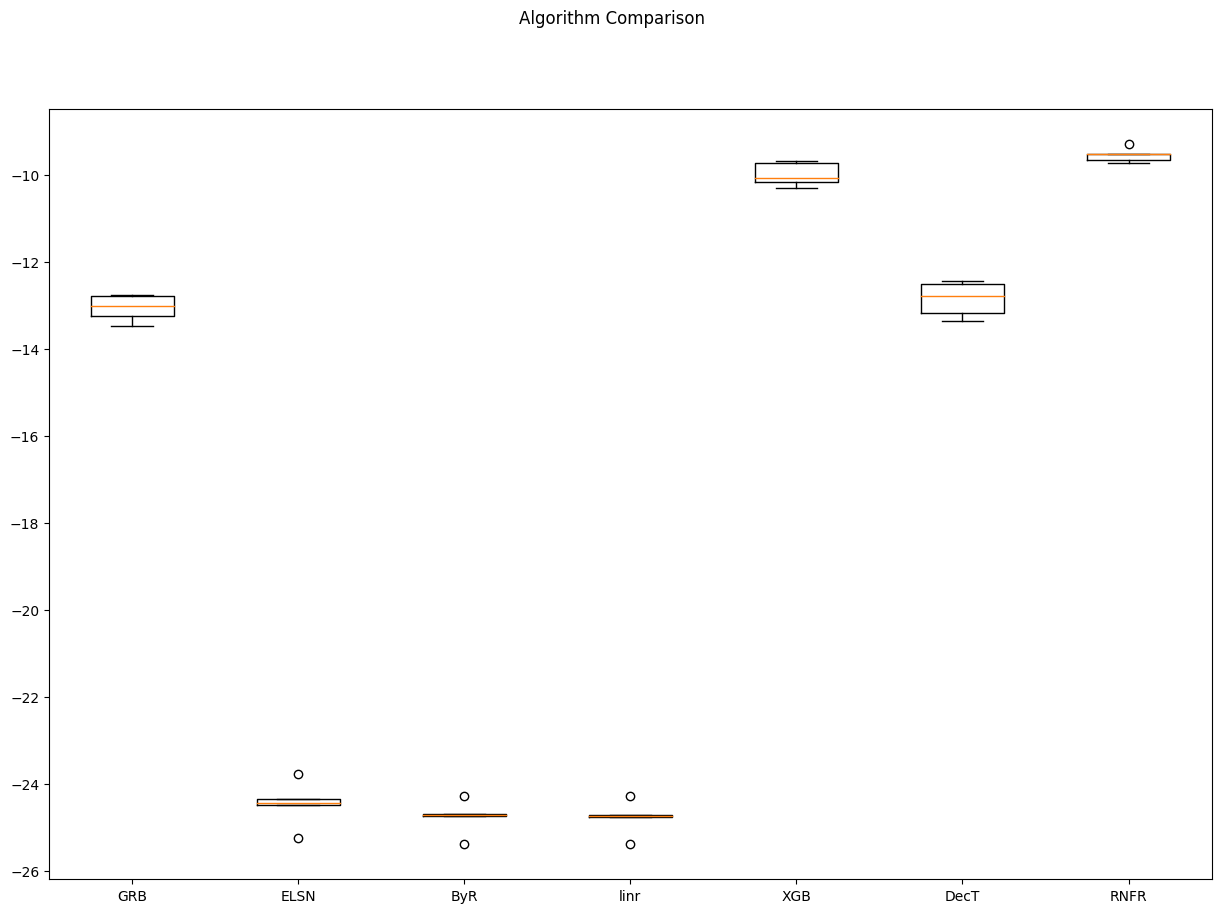

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
# from sklearn.kernel_ridge import KernelRidge
# from sklearn.svm import SVR
from sklearn.linear_model import (BayesianRidge, ElasticNet, LinearRegression)
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from xgboost.sklearn import XGBRegressor

models = [
    ('GRB', GradientBoostingRegressor()),
    # ('SVR', SVR()),
    # ('KernR', KernelRidge()),
    ('ELSN', ElasticNet()),
	('ByR', BayesianRidge()),
    ('linr', LinearRegression()),
    ('XGB', XGBRegressor(colsample_bytree=1, learning_rate=0.3, max_depth=5, n_estimators=150, subsample=1)),
    ('DecT', DecisionTreeRegressor()),
    ('RNFR', RandomForestRegressor())
]
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=5, random_state=0, shuffle=True)
    cv_results = cross_val_score(model, training_data, y_cas, cv=kfold, scoring = 'neg_mean_absolute_error')
    results.append(cv_results)
    names.append(name)
    print(name, -1 * cv_results.mean(), cv_results.std())
# boxplot algorithm comparison
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.savefig('Figures/Model_Comparison_Casual.png', format='png')
plt.show()

##  Model and GridSearch Selection

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(training_data, y_reg, test_size=0.3, random_state=0)

# Define the parameter grid for the grid search
param_grid = {
    'n_estimators': [10, 50, 100, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create a random forest regressor object
rf = RandomForestRegressor(random_state=42)

# Create a grid search object
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)


# Fit the grid search to the preprocessed data
grid_search.fit(X_train_reg, y_train_reg)

# Print the best parameters and score found by the grid search
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best Score: -3332.975274030873


In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

X_train_cas, X_test_cas, y_train_cas, y_test_cas = train_test_split(training_data, y_cas, test_size=0.3, random_state=0)

# Define the parameter grid for the grid search
param_grid = {
    'n_estimators': [10, 50, 100, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create a random forest regressor object
rf = RandomForestRegressor(random_state=42)

# Create a grid search object
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)


# Fit the grid search to the preprocessed data
grid_search.fit(X_train_cas, y_train_cas)

# Print the best parameters and score found by the grid search
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best Score: -302.07509755986814


In [ ]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(training_data, y_reg, test_size=0.3, random_state=0)
X_train_cas, X_test_cas, y_train_cas, y_test_cas = train_test_split(training_data, y_cas, test_size=0.3, random_state=0)

model_reg = RandomForestRegressor(max_depth=None, max_features='auto', min_samples_leaf=1, min_samples_split=2, n_estimators=500)
model_cas = RandomForestRegressor(max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=500)

model_reg.fit(X_train_reg, y_train_reg)
pred_reg = model_reg.predict(X_test_reg)
print(mean_absolute_error(y_test_reg, pred_reg))

model_cas.fit(X_train_cas, y_train_cas)
pred_cas = model_cas.predict(X_test_cas)
print(mean_absolute_error(y_test_cas, pred_cas))

37.26920879256703
9.48412252223866


- Saving the model.

In [ ]:
import pickle
# save the model to disk
filename_reg = 'finalized_model_reg.sav'
filename_cas = 'finalized_model_cas.sav'

pickle.dump(model_reg, open(filename_reg, 'wb'))
pickle.dump(model_cas, open(filename_cas, 'wb'))

- Loading the Model.

In [ ]:
# load the model from disk
loaded_model_reg = pickle.load(open(filename_reg, 'rb'))
result_reg = loaded_model_reg.predict(X_test_reg)

print(mean_absolute_error(result_reg, y_test_reg))

37.26920879256703


In [ ]:
# load the model from disk
loaded_model_cas = pickle.load(open(filename_cas, 'rb'))
result_cas = loaded_model_cas.predict(X_test_cas)

print(mean_absolute_error(result_cas, y_test_cas))

9.48412252223866
